# Sample Run with trVAE for Kang et. al dataset

In [1]:
import os
os.chdir("../")

In [3]:
import numpy as np
import scanpy as sc
import reptrvae
import pandas as pd 
from scipy import stats

Using TensorFlow backend.


In [4]:
sc.settings.set_figure_params(dpi=200)

In [5]:
data_name = "kang"
specific_celltype = "NK"
conditions = ['control', 'stimulated']
target_conditions = ["stimulated"]
cell_type_key = "cell_type"
condition_key = "condition"

In [6]:
adata = sc.read(f"./data/{data_name}/{data_name}_normalized.h5ad")
adata = adata[adata.obs[condition_key].isin(conditions)]
adata

View of AnnData object with n_obs × n_vars = 13576 × 2000 
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [7]:
adata.obs[cell_type_key].value_counts()

CD14 Mono    4362
CD4 T        4266
B            1366
CD16 Mono    1044
CD8 T         814
T             633
NK            619
DC            472
Name: cell_type, dtype: int64

In [8]:
adata.obs.groupby([cell_type_key, condition_key]).size()

cell_type  condition 
B          control        592
           stimulated     774
CD4 T      control       1837
           stimulated    2429
CD8 T      control        352
           stimulated     462
CD14 Mono  control       2215
           stimulated    2147
CD16 Mono  control        507
           stimulated     537
DC         control        258
           stimulated     214
NK         control        298
           stimulated     321
T          control        300
           stimulated     333
dtype: int64

In [9]:
adata.X.min(), adata.X.max()

(ArrayView(0., dtype=float32), ArrayView(6.941648, dtype=float32))

In [11]:
train_adata, valid_adata = reptrvae.utils.train_test_split(adata, 0.80)

In [12]:
train_adata.shape, valid_adata.shape

((10860, 2000), (2716, 2000))

In [13]:
net_train_adata = train_adata[~((train_adata.obs[cell_type_key] == specific_celltype) & (train_adata.obs[condition_key].isin(target_conditions)))]
net_valid_adata = valid_adata[~((valid_adata.obs[cell_type_key] == specific_celltype) & (valid_adata.obs[condition_key].isin(target_conditions)))]

In [14]:
net_train_adata.shape, net_valid_adata.shape

((10601, 2000), (2654, 2000))

In [15]:
net_train_adata.obs.groupby([cell_type_key, condition_key]).size()

cell_type  condition 
B          control        479
           stimulated     627
CD4 T      control       1475
           stimulated    1976
CD8 T      control        274
           stimulated     383
CD14 Mono  control       1738
           stimulated    1709
CD16 Mono  control        391
           stimulated     445
DC         control        197
           stimulated     171
NK         control        234
T          control        226
           stimulated     276
dtype: int64

In [16]:
network = reptrvae.models.trVAE(x_dimension=net_train_adata.shape[1],
                                z_dimension=20,
                                mmd_dimension=128, 
                                n_conditions=len(net_train_adata.obs[condition_key].unique()),
                                alpha=1e-6,
                                beta=500,
                                eta=100,
                                clip_value=1e6,
                                lambda_l1=0.0,
                                lambda_l2=0.0,
                                learning_rate=0.001,
#                                 model_path=f"./models/trVAEMulti/best/{data_name}-{specific_celltype}/",
                                dropout_rate=0.2,
                                output_activation='relu')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 2)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 2002)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
_____________________

In [17]:
label_encoder = {'control': 0, 'stimulated': 1}

In [17]:
# network.restore_model()

In [20]:
network.train(net_train_adata,
              net_valid_adata,
              label_encoder,
              condition_key,
              n_epochs=10000,
              batch_size=128,
              verbose=2,
              early_stop_limit=500,
              lr_reducer=400,
              shuffle=True,
              )

Instructions for updating:
Use tf.cast instead.
Train on 10607 samples, validate on 2648 samples
Epoch 1/10000
 - 2s - loss: 4463.0484 - kl_mse_loss: 4428.0491 - mmd_loss: 34.9993 - val_loss: 8817.6247 - val_kl_mse_loss: 8817.6247 - val_mmd_loss: 0.0000e+00
Epoch 2/10000
 - 1s - loss: 3240.9132 - kl_mse_loss: 3207.8667 - mmd_loss: 33.0466 - val_loss: 3003.0548 - val_kl_mse_loss: 2966.8287 - val_mmd_loss: 36.2261
Epoch 3/10000
 - 1s - loss: 3088.4608 - kl_mse_loss: 3059.7494 - mmd_loss: 28.7114 - val_loss: 2965.6762 - val_kl_mse_loss: 2941.5021 - val_mmd_loss: 24.1741
Epoch 4/10000
 - 1s - loss: 2991.3669 - kl_mse_loss: 2964.9172 - mmd_loss: 26.4497 - val_loss: 2829.4849 - val_kl_mse_loss: 2799.6922 - val_mmd_loss: 29.7928
Epoch 5/10000
 - 1s - loss: 2920.6968 - kl_mse_loss: 2895.6228 - mmd_loss: 25.0741 - val_loss: 2787.2821 - val_kl_mse_loss: 2763.2321 - val_mmd_loss: 24.0500
Epoch 6/10000
 - 1s - loss: 2872.0726 - kl_mse_loss: 2848.2042 - mmd_loss: 23.8684 - val_loss: 2702.3376 - val

In [18]:
train_labels, _ = trvae.tl.label_encoder(net_train_adata, label_encoder, condition_key)
latent_with_true_labels = network.to_latent(net_train_adata, train_labels)
mmd_with_true_labels = network.to_mmd_layer(net_train_adata, train_labels, feed_fake=-1)

/home/icb/mohsen.naghipourfar/.local/lib/python3.6/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../.local/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


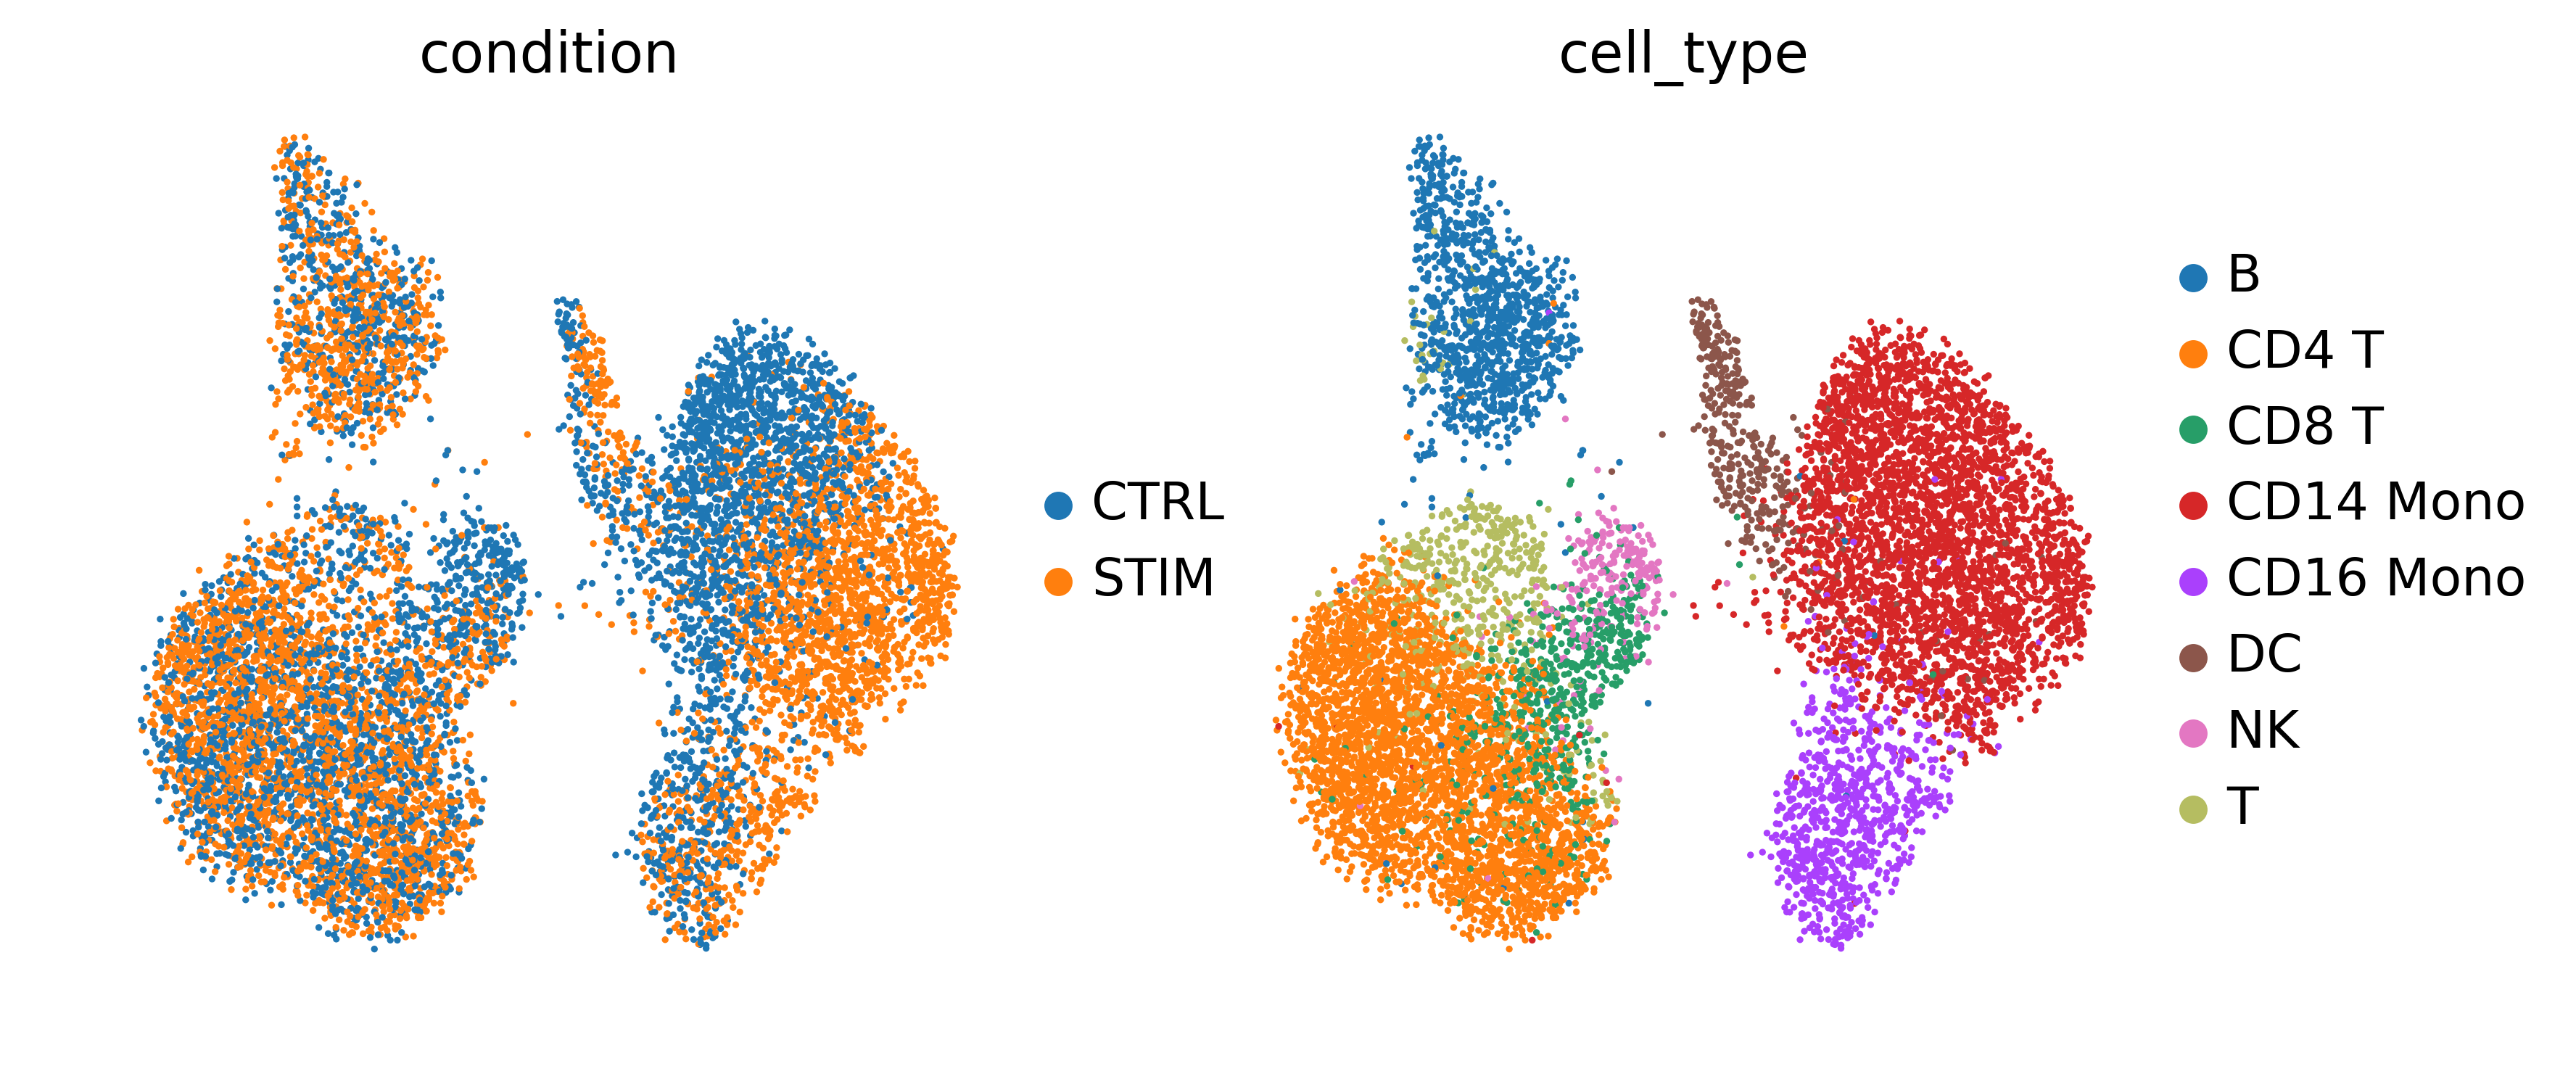

In [26]:
sc.pp.neighbors(latent_with_true_labels)
sc.tl.umap(latent_with_true_labels)
sc.pl.umap(latent_with_true_labels, color=[condition_key, cell_type_key],
           show=True,
           wspace=0.15,
           frameon=False)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/mohsen/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


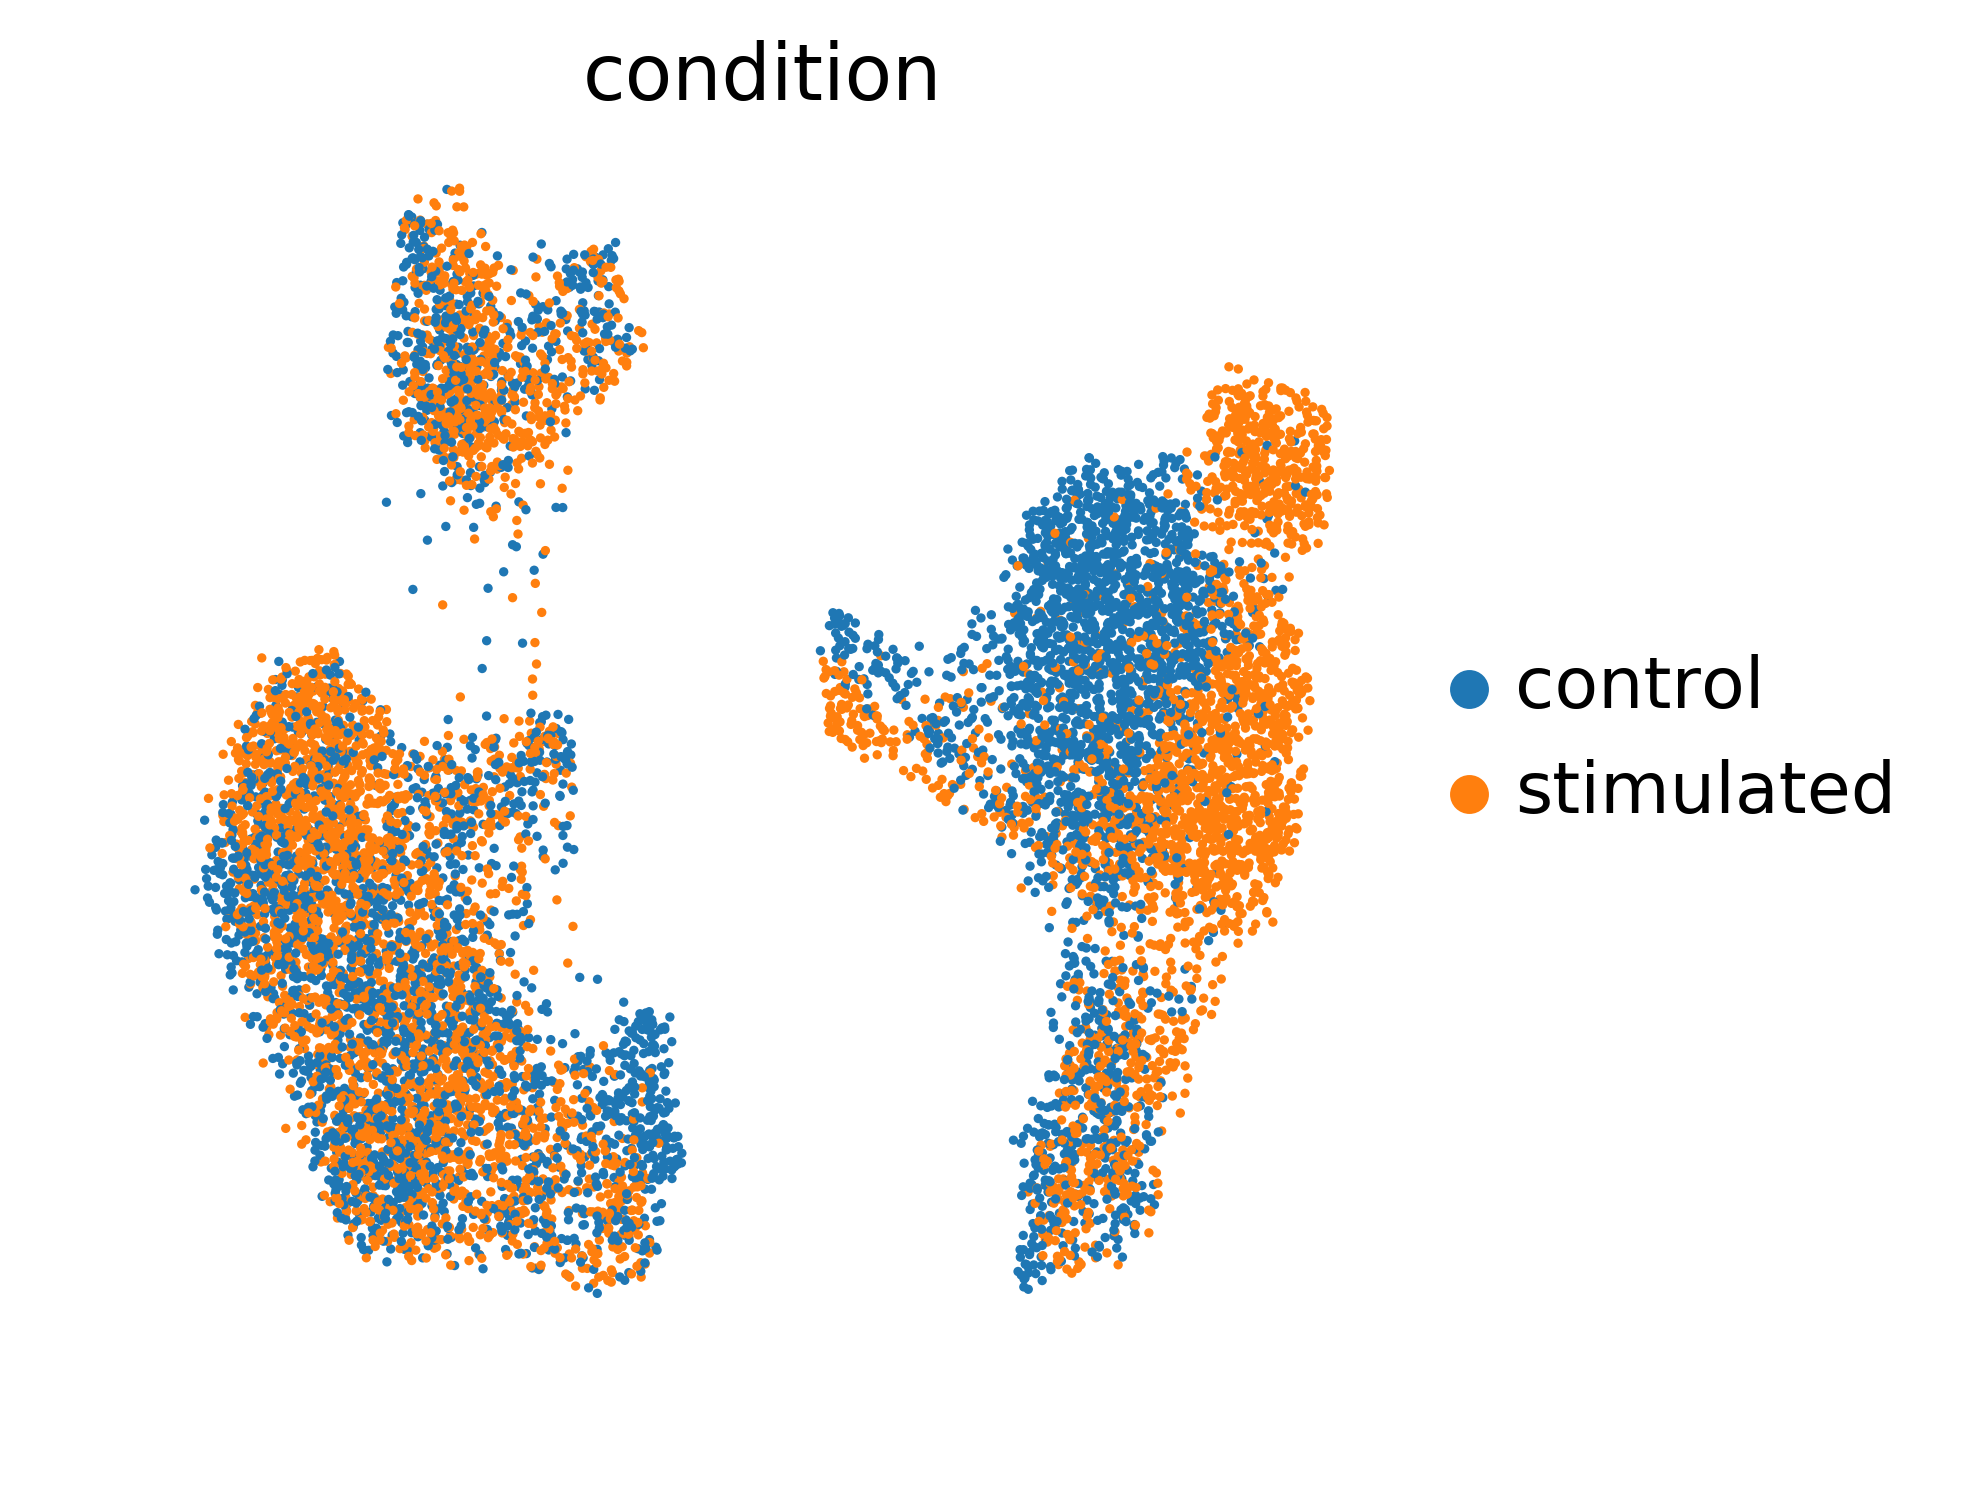

In [20]:
sc.pp.neighbors(mmd_with_true_labels)
sc.tl.umap(mmd_with_true_labels)
sc.pl.umap(mmd_with_true_labels, color=condition_key,
           show=True,
           save="_trVAE_MMD_condition.png",
           wspace=0.15,
           frameon=False)

In [28]:
cell_type_adata = train_adata[train_adata.obs[cell_type_key] == specific_celltype]

In [29]:
cell_type_adata.var = pd.DataFrame(index=cell_type_adata.var_names)

In [30]:
cell_type_adata.obs.groupby([cell_type_key, condition_key]).size()

cell_type  condition
NK         CTRL         245
           STIM         260
dtype: int64

In [31]:
def predict_transition(adata, source_cond, target_cond):
    
    source_adata = adata[adata.obs[condition_key] == source_cond]
    
    source_cond_key = source_cond.split("_to_")[-1]
    source_labels = np.zeros(source_adata.shape[0]) + label_encoder[source_cond_key]
    target_labels = np.zeros(source_adata.shape[0]) + label_encoder[target_cond]

    pred_target = network.predict(source_adata,
                                  encoder_labels=source_labels,
                                  decoder_labels=target_labels,
                                  )

    pred_adata = sc.AnnData(X=pred_target)
    pred_adata.obs[condition_key] = [source_cond + "_to_" + target_cond] * pred_target.shape[0]
    pred_adata.obs[cell_type_key] = [specific_celltype] * pred_target.shape[0]
    pred_adata.var_names = source_adata.var_names

    adata = adata.concatenate(pred_adata)
    return adata

In [32]:
recon_adata = predict_transition(cell_type_adata, "CTRL", "STIM")
recon_adata

AnnData object with n_obs × n_vars = 750 × 2000 
    obs: 'batch', 'cell_type', 'condition', 'integrated_snn_res.0.5', 'nCount_RNA', 'nFeature_RNA', 'n_counts', 'orig.ident', 'seurat_annotations', 'seurat_clusters', 'stim'

In [33]:
recon_adata.obs.groupby([cell_type_key, condition_key]).size()

cell_type  condition   
NK         CTRL            245
           CTRL_to_STIM    245
           STIM            260
dtype: int64

In [34]:
path = "CTRL_to_STIM"
from_condition = path.split("_to_")[-2]
to_condition = path.split("_to_")[-1]

In [35]:
pred_adata = recon_adata[recon_adata.obs[condition_key] == path]
pred_adata

View of AnnData object with n_obs × n_vars = 245 × 2000 
    obs: 'batch', 'cell_type', 'condition', 'integrated_snn_res.0.5', 'nCount_RNA', 'nFeature_RNA', 'n_counts', 'orig.ident', 'seurat_annotations', 'seurat_clusters', 'stim'

In [36]:
ctrl_adata = cell_type_adata[cell_type_adata.obs[condition_key] == from_condition]
ctrl_adata

View of AnnData object with n_obs × n_vars = 245 × 2000 
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'n_counts'

In [37]:
real_adata = cell_type_adata[cell_type_adata.obs[condition_key] == to_condition]
real_adata = trvae.utils.remove_sparsity(real_adata)
real_adata

View of AnnData object with n_obs × n_vars = 260 × 2000 
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'n_counts'

In [38]:
real_adata.X.min(), real_adata.X.max()

(ArrayView(0., dtype=float32), ArrayView(5.0732174, dtype=float32))

In [39]:
pred_adata.X.min(), pred_adata.X.max()

(ArrayView(0., dtype=float32), ArrayView(5.0386763, dtype=float32))

In [40]:
pred_adata = trvae.utils.remove_sparsity(pred_adata)

In [41]:
pred_mean = np.mean(pred_adata.X, axis=0)
real_mean = np.mean(real_adata.X, axis=0)

In [42]:
pred_var = np.var(pred_adata.X, axis=0)
real_var = np.var(real_adata.X, axis=0)

In [43]:
m, b, r_value_mean, p_value, std_err = stats.linregress(pred_mean, real_mean)
r_value_mean = r_value_mean ** 2
r_value_mean

0.9684558654342762

In [44]:
m, b, r_value_var, p_value, std_err = stats.linregress(pred_var, real_var)
r_value_var = r_value_var ** 2
r_value_var

0.6971445493228465

In [45]:
adata_pred = ctrl_adata.concatenate(pred_adata, real_adata)
adata_pred

AnnData object with n_obs × n_vars = 750 × 2000 
    obs: 'batch', 'cell_type', 'condition', 'integrated_snn_res.0.5', 'nCount_RNA', 'nFeature_RNA', 'n_counts', 'orig.ident', 'seurat_annotations', 'seurat_clusters', 'stim'

In [46]:
adata_pred.obs[condition_key].unique()

array(['CTRL', 'CTRL_to_STIM', 'STIM'], dtype=object)

In [47]:
sc.tl.rank_genes_groups(cell_type_adata,
                        groupby=condition_key,
                        groups=[to_condition],
                        reference=from_condition,
                        n_genes=100)

In [48]:
top_genes = cell_type_adata.uns['rank_genes_groups']['names'][to_condition]

reg_mean_top100: 0.9862900882058669
reg_mean_all: 0.9684558654342762


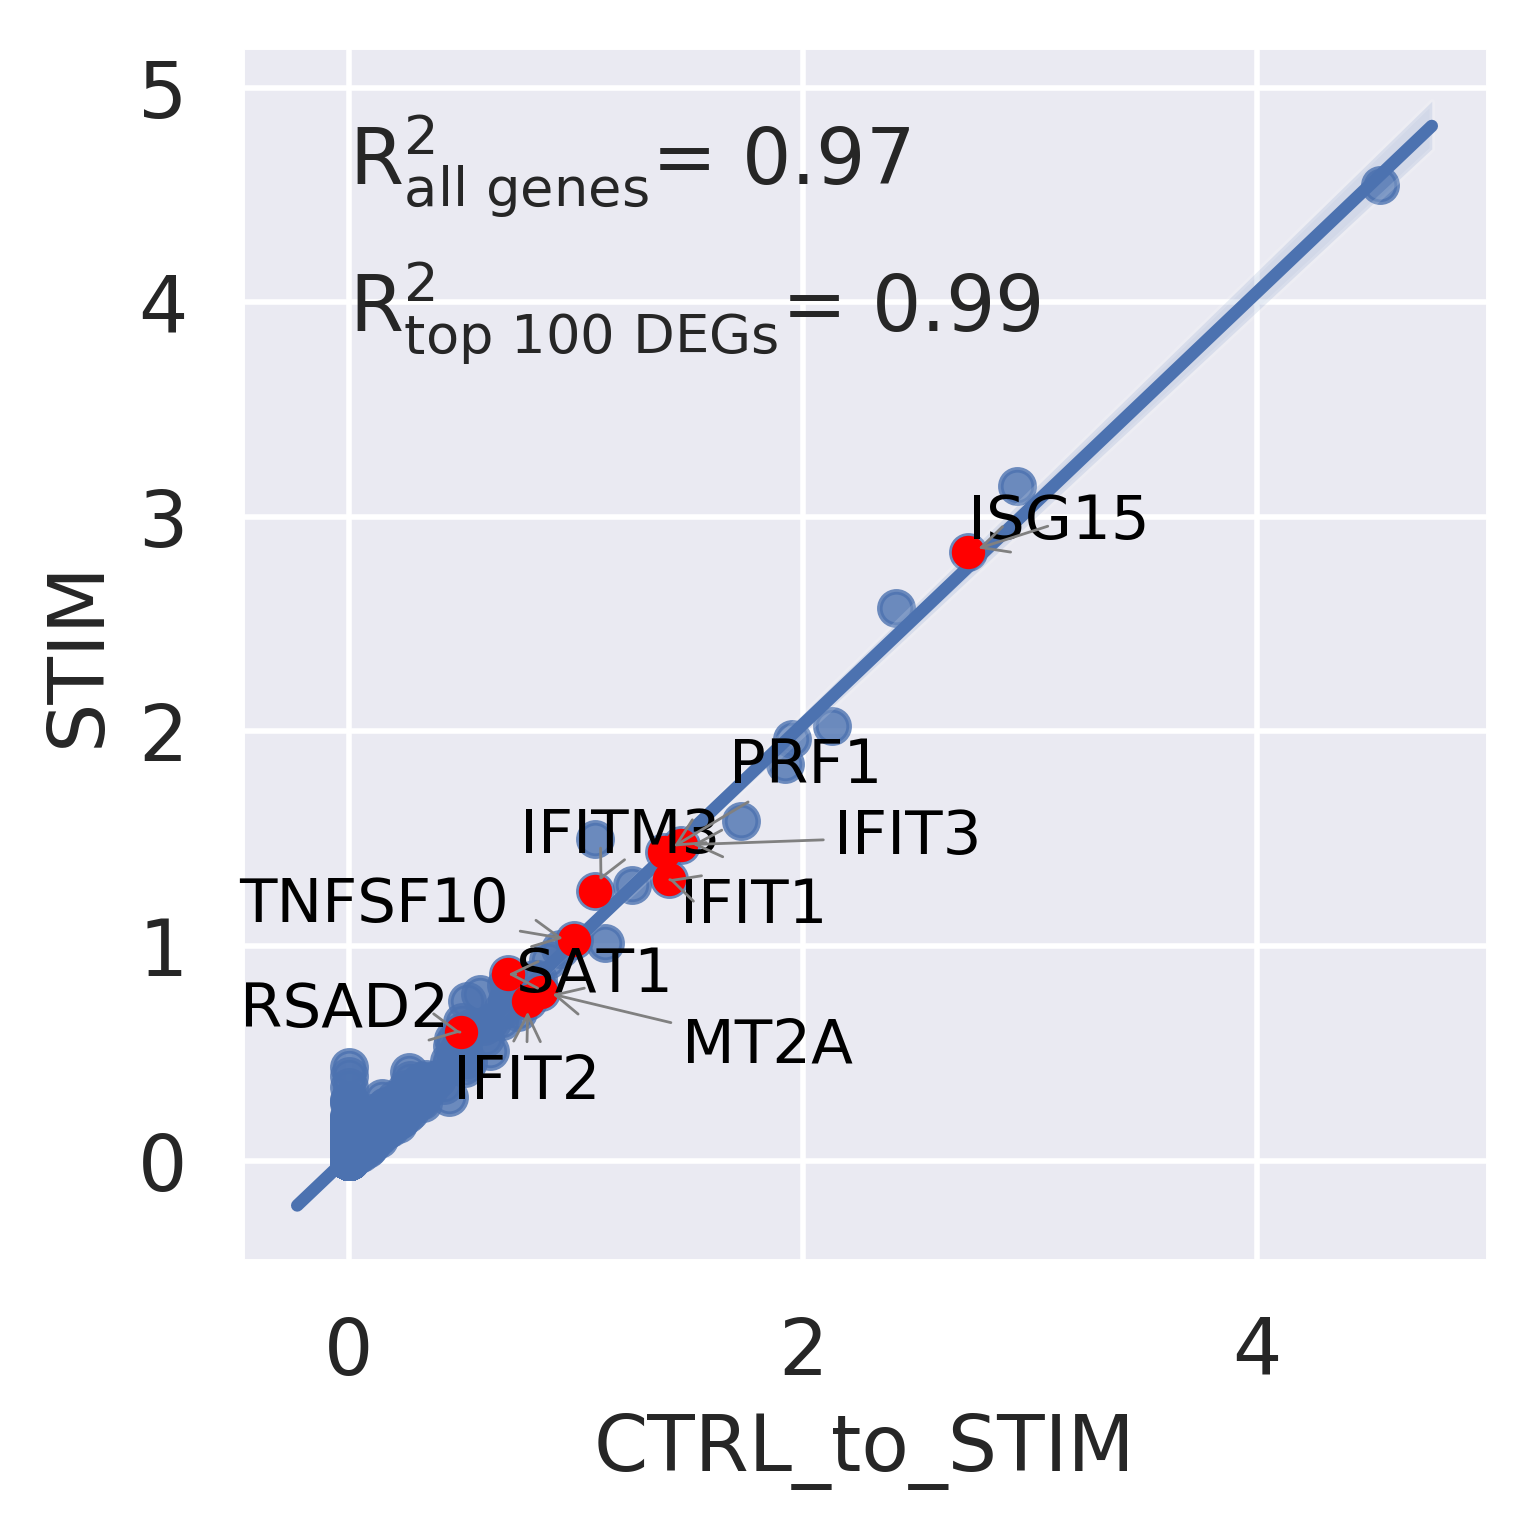

In [49]:
trvae.pl.reg_mean_plot(adata_pred,
                         top_100_genes=top_genes,
                         gene_list=top_genes[:10],
                         condition_key=condition_key,
                         axis_keys={'x': path, 'y': to_condition},
                         labels={'x': path, 'y': to_condition},
                         path_to_save=None,
                         legend=False,
                         show=True,
                         x_coeff=1.0,
                         y_coeff=0.0)

reg_var_top100: 0.7397072503106951
reg_var_all: 0.6971445493228465


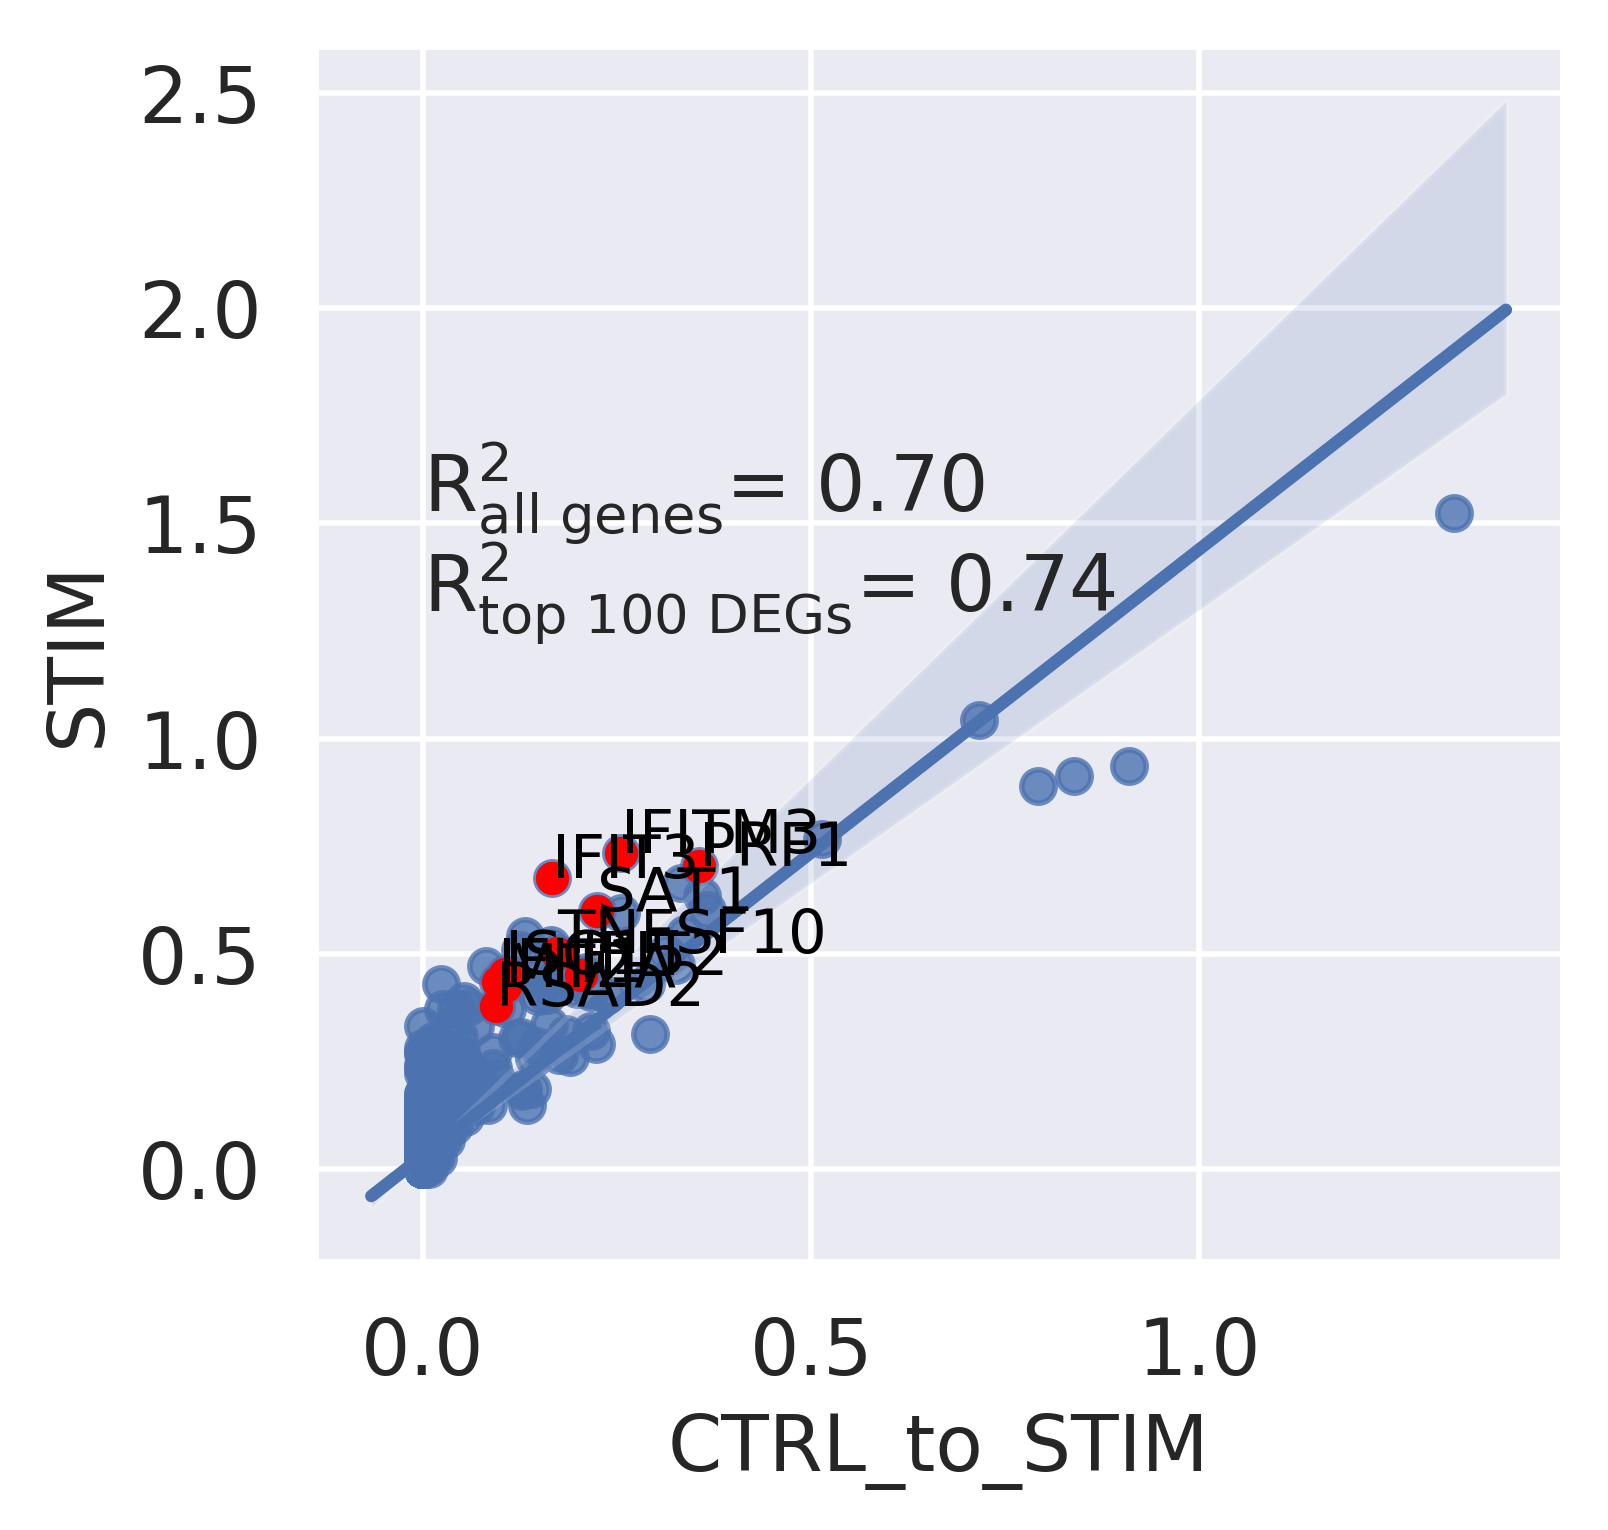

In [50]:
trvae.pl.reg_var_plot(adata_pred,
                     top_100_genes=top_genes,
                     gene_list=top_genes[:10],
                     condition_key=condition_key,
                     axis_keys={'x': path, 'y': to_condition},
                     labels={'x': path, 'y': to_condition},
                     path_to_save=None,
                     legend=False,
                     show=True,
                     x_coeff=1.0,
                     y_coeff=0.0)

In [54]:
top_genes

array(['ISG15', 'IFIT1', 'IFIT3', 'IFITM3', 'TNFSF10', 'IFIT2', 'RSAD2',
       'PRF1', 'MT2A', 'SAT1', 'B2M', 'OASL', 'CD38', 'ANXA1', 'RTP4',
       'CXCL10', 'HSPA5', 'C5orf56', 'ODF2L', 'CCL8', 'SELL', 'CD69',
       'HERPUD1', 'SOCS1', 'TNFSF13B', 'SDF2L1', 'FASLG', 'PRR5', 'GBP5',
       'TARBP1', 'NEXN', 'RARRES3', 'CLEC2D', 'SLAMF7', 'PMAIP1', 'WARS',
       'GZMA', 'VAMP5', 'GZMB', 'APOBEC3A', 'SLFN5', 'KLF6', 'GNLY',
       'PTPN4', 'NUCB2', 'ALOX5AP', 'ANXA2R', 'VPS37B', 'CCL7', 'CEBPD',
       'SEC11C', 'HSPA1A', 'GIMAP4', 'IL2RA', 'FUNDC1', 'L3MBTL3',
       'SMAGP', 'CHST12', 'CALCOCO2', 'IL2RB', 'CCL2', 'HAPLN3', 'IFNG',
       'SBK1', 'UTRN', 'RGS1', 'CDK2AP2', 'TRAPPC2', 'IDO1', 'FAS',
       'APOBEC3B', 'STAT3', 'FANCF', 'PIM1', 'S100A11', 'NCALD', 'SMNDC1',
       'EMB', 'IL1RN', 'PATL2', 'HES4', 'ANKRD49', 'DDHD1', 'CCL3',
       'SYTL3', 'TAGAP', 'CXCL11', 'AF131217.1', 'MRPL18', 'TMEM106C',
       'LAG3', 'ICOS', 'CLDND1', 'CTD-2521M24.9', 'SLC39A6', 'PAXIP1-AS2',

In [53]:
adata_pred.obs[condition_key].value_counts()

STIM            260
CTRL_to_STIM    245
CTRL            245
Name: condition, dtype: int64

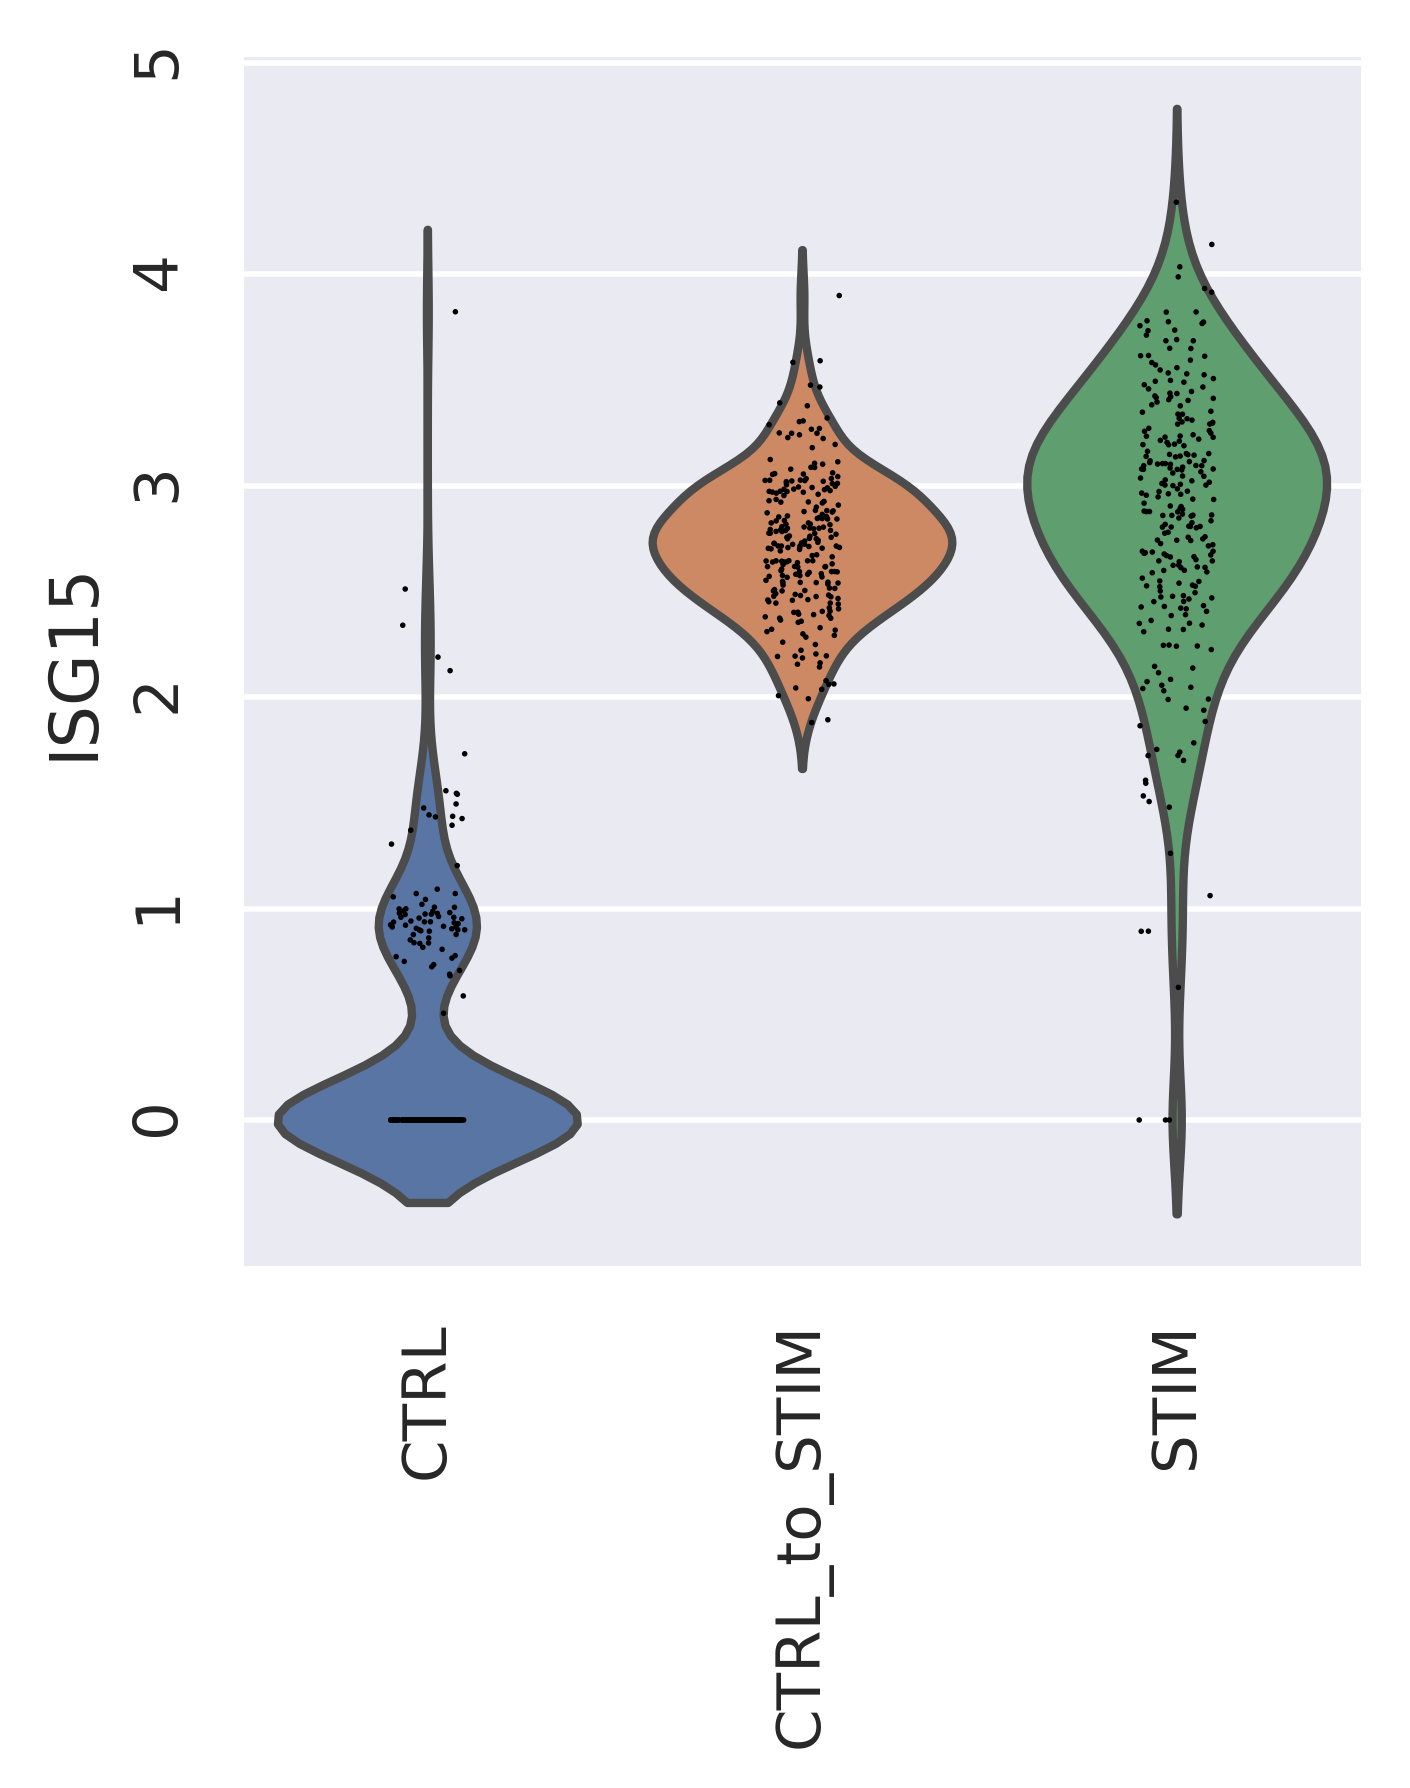

In [57]:
sc.pl.violin(adata_pred, groupby=condition_key, keys=top_genes[0], rotation=90)

In [58]:
recon_adata.write_h5ad(f"../trVAE_reproducibility/data/reconstructed/trVAE_{data_name}/{specific_celltype}.h5ad")

... storing 'cell_type' as categorical
... storing 'condition' as categorical
... storing 'orig.ident' as categorical
... storing 'stim' as categorical


In [59]:
network.model_to_use = f"./models/trVAEMulti/best/{data_name}-{specific_celltype}/"

In [60]:
network.model_to_use

'./models/trVAEMulti/best/kang-NK/'

In [61]:
network.save_model()